In [1]:
import cv2
from ultralytics import YOLO
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
sys.path.append(os.path.abspath('..'))

from src.const import *
from src.morph import color_mask, dilate, erode, opening, closing, external_border

In [2]:
DISTANCE_HULL = 10

range_white = 45

lower_white = [max(0, c - range_white) for c in WHITE_CHESS]
upper_white = [min(240, c + range_white) for c in WHITE_CHESS]

"""
Custom YOLO train over Roboflow dataset on corner of chessboard
"""
# model = YOLO(r'C:\Users\Student11\Documents\git\ELEN-CV\project\yolo\yolo11n_custom6h.pt')
model = YOLO(r'..\weights\best.pt')
model2 = YOLO(r'..\weights\best11m.pt')

In [3]:
def double_detect_yolo(frame):

    hull, combined_contour = external_border(frame, lower_white, upper_white)

    # draw the convex hull on the frame
    cv2.drawContours(frame, [hull], -1, (0, 255, 0), 3)

    # scale factor horizontal and vertical
    fx = 640 / frame_width
    fy = 640 / frame_height
    
    frame_resized = cv2.resize(frame, (640, 640), interpolation=cv2.INTER_AREA)

    # Result of the corners detection with YOLO
    results = model.track(source=frame, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)
    results2 = model2.track(source=frame, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)
    
    results.extend(results2)
    
    results_resized = model.track(source=frame_resized, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)
    results2_resized = model2.track(source=frame_resized, persist=True, verbose=False, show=False, tracker="bytetrack.yaml", conf=0.1, iou=0.1)
    
    results_resized.extend(results2_resized)

    bbox_data = []
    
    for result in results_resized:
        for box in result.boxes:
            # Resized frame coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            confidence = box.conf[0].item()
            # check box is already tracked if not, no id
            if box.id is not None:
                label = int(box.id.item())
            else:
                label = 99
            label_text = f"{confidence:.2f}"
            
            # Map to original frame coordinates
            x1_original, y1_original = x1 / fx, y1 / fy
            x2_original, y2_original = x2 / fx, y2 / fy
            
            # Calculate the center of the bounding box
            cx_resized, cy_resized = (x1 + x2) / 2, (y1 + y2) / 2
            cx_original, cy_original = cx_resized / fx, cy_resized / fy
            
            distance = cv2.pointPolygonTest(hull, (cx_original, cy_original), True)
            if distance < -DISTANCE_HULL:
                continue  # Skip this prediction if the center is not inside the hull or within 10 pixels

            bbox_data.append((cx_original, cy_original, x1_original, y1_original, x2_original, y2_original))  # Store center and box dimensions

            # Visualize the results on the original frame
            # cv2.circle(frame, (int(cx_original), int(cy_original)), 3, BLUE, -1)
            cv2.rectangle(frame, (int(x1_original), int(y1_original)), (int(x2_original), int(y2_original)), ORANGE, 2)
            # cv2.putText(frame, label_text, (int(x1_original), int(y1_original) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, BLACK, 2)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            confidence = box.conf[0].item()
            # check box is already tracked if not, no id
            if box.id is not None:
                label = int(box.id.item())
            else:
                label = 99
            label_text = f"{confidence:.2f}"

            cx, cy = (x1 + x2) / 2, (y1 + y2) / 2  # Center of the bounding box

            # Check if the center of the bounding box is inside the hull or within 10 pixels
            distance = cv2.pointPolygonTest(hull, (cx, cy), True)
            if distance < -DISTANCE_HULL:
                continue 
                
            bbox_data.append((cx, cy, x1, y1, x2, y2))

            # Visualize the results on the original frame
            cv2.circle(frame, (int(cx), int(cy)), 3, BLUE, -1)
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), ORANGE, 2)
            cv2.putText(frame, label_text, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, BLACK, 2)         

    return bbox_data, frame

def cluster_boxes(bbox):

    # Group bounding boxes using DBSCAN with a maximum distance of 100 pixels

    bbox_centers = np.array([[data[0], data[1]] for data in bbox])  # Only centers
    clustering = DBSCAN(eps=200, min_samples=1).fit(bbox_centers)  # eps = 100 pixels

    clusters = {}
    for idx, label in enumerate(clustering.labels_):
        if label not in clusters:
            clusters[label] = []
        # Add full bounding box data to the cluster
        clusters[label].append(bbox[idx])  

    # Compute the average bounding box for each cluster
    averaged_bboxes = []
    for cluster_id, boxes in clusters.items():
        # Average the coordinates of the bounding boxes in the cluster
        avg_x1 = int(np.mean([box[2] for box in boxes]))
        avg_y1 = int(np.mean([box[3] for box in boxes]))
        avg_x2 = int(np.mean([box[4] for box in boxes]))
        avg_y2 = int(np.mean([box[5] for box in boxes]))
        # Center of the averaged bounding box
        avg_cx, avg_cy = (avg_x1 + avg_x2) // 2, (avg_y1 + avg_y2) // 2  
        averaged_bboxes.append((avg_x1, avg_y1, avg_x2, avg_y2, avg_cx, avg_cy))

    return averaged_bboxes

def id_corner_chessboard(corners, clustered_bboxes, frame):

    for bbox in clustered_bboxes:

        x1, y1, x2, y2, cx, cy = bbox
        label_text = ""
        
        
        # Determine which corner the center belongs to
        if cx < frame.shape[1] / 2 and cy < frame.shape[0] / 2:
            corners["h8"][0], corners["h8"][1] = cx, cy
            label_text += " h8"
            
        elif cx >= frame.shape[1] / 2 and cy < frame.shape[0] / 2:
            corners["h1"][0], corners["h1"][1] = cx, cy
            label_text += " h1"

        elif cx < frame.shape[1] / 2 and cy >= frame.shape[0] / 2:
            corners["a8"][0], corners["a8"][1] = cx, cy
            label_text += " a8"

        elif cx >= frame.shape[1] / 2 and cy >= frame.shape[0] / 2:
            corners["a1"][0], corners["a1"][1] = cx, cy
            label_text += " a1"
            
        cv2.circle(frame, (int(cx), int(cy)), 3, BLUE, -1)
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), GREEN, 2)
        cv2.putText(frame, label_text, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 1, BLACK, 2)

    return corners

def corner_id_yolo(frame):

    # Initialize corner coordinates
    corners = {
        "h8": [None, None],
        "h1": [None, None],
        "a8": [None, None],
        "a1": [None, None]
    }

    bbox_data, frame = double_detect_yolo(frame)

    clustered_boxes = cluster_boxes(bbox_data)

    if len(clustered_boxes) >= 4:
        centroid_x = sum([c[4] for c in clustered_boxes]) / len(clustered_boxes)
        centroid_y = sum([c[5] for c in clustered_boxes]) / len(clustered_boxes)

        cv2.circle(frame, (int(centroid_x), int(centroid_y)), 7, RED, -1)

    corners = id_corner_chessboard(corners, clustered_boxes, frame) 

    # for corner, coord in corners.items():
        # if all(c is None for c in coord):
            # print(f"{corner}: (x,x)", end=" | ")
        # else:
            # print(f"{corner}:({coord[0]},{coord[1]})", end=" | ")
    # print()

    return corners

Frame Rate :  29 frames per second
Frame count :  12457.0
Frame width :  1920.0
Frame height :  1080.0


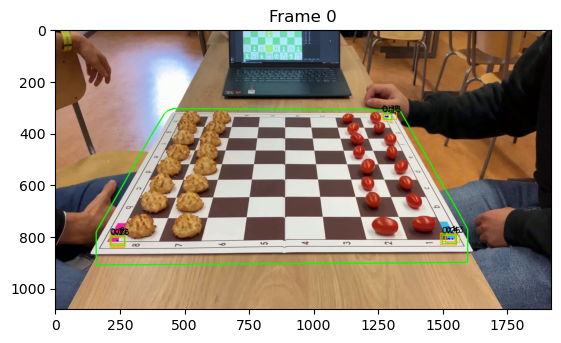

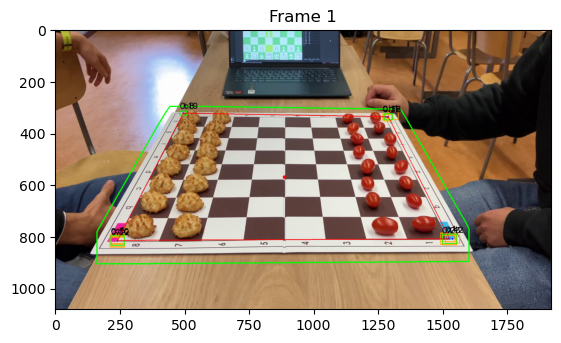

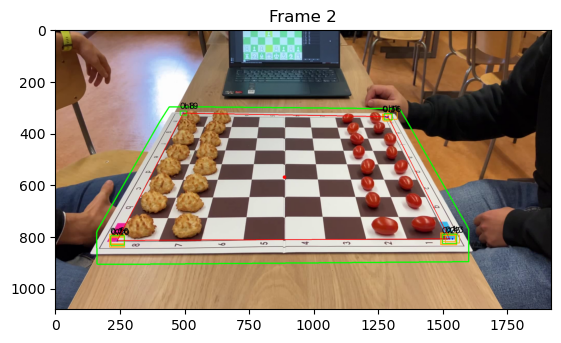

In [5]:
# !!!!! not use  mov, doesnt work, convert to avi
video_path = r'..\video\IMG_0485.avi'

cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error opening the video file")
    exit()
else:
    # Get frame rate information
    fps = int(cap.get(5))
    print("Frame Rate : ",fps,"frames per second")  
    
    # Get frame count, if you see -1, the video is not good
    frame_count = cap.get(7)
    print("Frame count : ", frame_count)
    
    # Get the width and height of frame
    frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    print("Frame width : ", frame_width)
    print("Frame height : ", frame_height)

frame_idx = 0

while True:
    ret, frame = cap.read()

    if not ret:
        print("End of video stream or error reading the video.")
        break

    corners = corner_id_yolo(frame)

    if all([c[0] is not None and c[1] is not None for c in corners.values()]):
        pts = np.array([
            [int(corners["h8"][0]), int(corners["h8"][1])],
            [int(corners["h1"][0]), int(corners["h1"][1])],
            [int(corners["a1"][0]), int(corners["a1"][1])],
            [int(corners["a8"][0]), int(corners["a8"][1])]
        ], np.int32)

        pts = pts.reshape((-1, 1, 2))
        cv2.polylines(frame, [pts], isClosed=True, color=RED, thickness=2)


    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f'Frame {frame_idx}')
    plt.show()

    frame_idx += 1

    if frame_idx >= 3:
        break
        
# Release the video capture
cap.release()

# Close all OpenCV windows
cv2.destroyAllWindows()